# Import Package

In [1]:
# pip install transformers
# pip install torch
# pip install arabert
# pip install Dataset
from datasets import Dataset
import transformers
import torch
import arabert
import dataset
import emoji

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as creport
from multiprocessing import Pool


# Data ِِAnalysis

In [3]:
train_data = pd.read_csv('train_data.csv')
train_data.head()

Tweet Offensive    Hate
0  الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...   NOT_OFF  NOT_HS
1            فدوه يا بخت فدوه يا زمن واحد منكم يجيبه   NOT_OFF  NOT_HS
2  RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...       OFF      HS
3  RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...   NOT_OFF  NOT_HS
4          يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼   NOT_OFF  NOT_HS

In [4]:
dev_data = pd.read_csv('dev_data.csv')
dev_data.head()

Tweet Offensive    Hate
0  فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...   NOT_OFF  NOT_HS
1  RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...   NOT_OFF  NOT_HS
2  يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...   NOT_OFF  NOT_HS
3  RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...   NOT_OFF  NOT_HS
4     RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL   NOT_OFF  NOT_HS

In [5]:
print("Train data shape:{} \nDev data shape: {}".format(train_data.shape,dev_data.shape))


Train data shape:(7000, 3) 
Dev data shape: (1000, 3)


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      7000 non-null   object
 1   Offensive  7000 non-null   object
 2   Hate       7000 non-null   object
dtypes: object(3)
memory usage: 164.2+ KB


In [7]:
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      1000 non-null   object
 1   Offensive  1000 non-null   object
 2   Hate       1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


Text(0.5, 0, 'label')

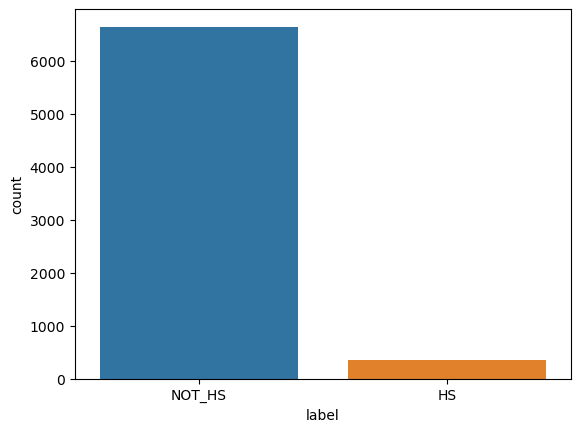

In [8]:
sns.countplot(x=train_data.Hate)
plt.xlabel('label')

Text(0.5, 0, 'label')

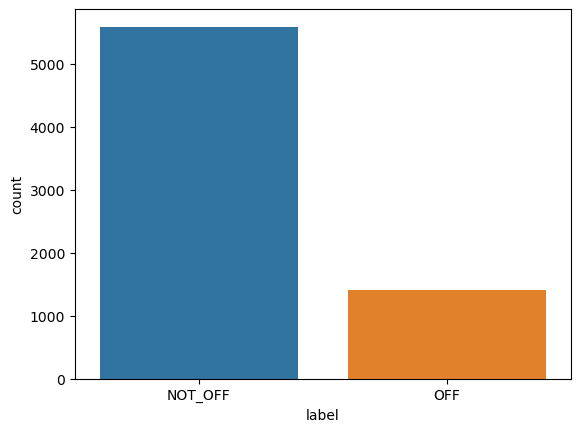

In [9]:
sns.countplot(x=train_data.Offensive)
plt.xlabel('label')

# Data Augmentation

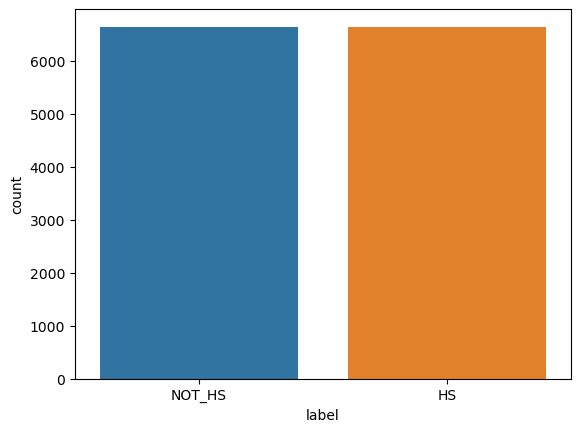

In [10]:
from imblearn.over_sampling import RandomOverSampler

X = train_data.drop('Hate', axis=1)
y = train_data['Hate']

ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X, y)

balanced_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['Hate'])], axis=1)

sns.countplot(x=balanced_data.Hate)
plt.xlabel('label')
plt.show()


In [11]:
balanced_data.shape

(13278, 3)

# Data preprocessing

In [12]:
def clean(df):
    df = remove_diacritics(df)
    df = normalize_arabic(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df = remove_english_word_and_numbers(df)
    df = remove_emoji(df)
    df = clean_space(df)
    return df

In [13]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


In [14]:
def remove_diacritics(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x

def remove_punctuations(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_punctuations(x))
    return df
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_repeating_char(x))
    return df
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['Tweet'] = df["Tweet"].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)

def remove_emoji(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_emoji(x) if isinstance(x, str) else x)
    return df

def _remove_emoji(text):
    return emoji.get_emoji_regexp().sub(" ", text)



In [15]:
train_data_cleaned = clean(balanced_data)
test_data_cleaned = clean(dev_data)

In [16]:
train_df, val_df = train_test_split(train_data_cleaned, test_size=0.09, random_state=42)

# data_train = Dataset.from_pandas(train_df)
# data_val = Dataset.from_pandas(val_df)

data_train = pd.DataFrame(train_df)
data_val = pd.DataFrame(val_df)
data_test = test_data_cleaned

In [17]:
print(f"Train Data Size : {data_train.shape}\nValidation Data Size : {data_val.shape}\nTest Data Size : {test_data_cleaned.shape}")

Train Data Size : (12082, 3)
Validation Data Size : (1196, 3)
Test Data Size : (1000, 3)


In [ ]:
train_data_cleaned.to_csv("train_data_cleaned.csv", index=False)
test_data_cleaned.to_csv("test_data_cleaned.csv", index=False)

In [18]:
print("TRAIN DATA")
print("tweets labeled as offensive and hate speech:\n", len(train_data_cleaned .query("Offensive == 'OFF' & Hate != 'NOT_HS'")))
print("tweets labeled as inoffensive and hate speech:\n", len(train_data_cleaned .query("Offensive == 'NOT_OFF' & Hate != 'NOT_HS'"))) # labels are well-maintained
print("tweets labeled as offensive only and not hate speech:\n", len(train_data_cleaned .query("Offensive == 'OFF' & Hate == 'NOT_HS'")))
print("tweets labeled as inoffensive and not hate speech:\n", len(train_data_cleaned .query("Offensive == 'NOT_OFF' & Hate == 'NOT_HS'")))

print("TEST DATA")

print("tweets labeled as offensive and hate speech:\n", len(test_data_cleaned .query("Offensive == 'OFF' & Hate != 'NOT_HS'")))
print("tweets labeled as inoffensive and hate speech:\n", len(test_data_cleaned .query("Offensive == 'NOT_OFF' & Hate != 'NOT_HS'"))) # labels are well-maintained
print("tweets labeled as offensive only and not hate speech:\n", len(test_data_cleaned .query("Offensive == 'OFF' & Hate == 'NOT_HS'")))
print("tweets labeled as inoffensive and not hate speech:\n", len(test_data_cleaned .query("Offensive == 'NOT_OFF' & Hate == 'NOT_HS'")))


TRAIN DATA
tweets labeled as offensive and hate speech:
 6639
tweets labeled as inoffensive and hate speech:
 0
tweets labeled as offensive only and not hate speech:
 1049
tweets labeled as inoffensive and not hate speech:
 5590
TEST DATA
tweets labeled as offensive and hate speech:
 44
tweets labeled as inoffensive and hate speech:
 0
tweets labeled as offensive only and not hate speech:
 135
tweets labeled as inoffensive and not hate speech:
 821


# Data preparation

In [19]:
def label_map(df):
    hate_mapping = {'HS': 1, 'NOT_HS': 0}
    offensive_mapping = {'OFF': 1, 'NOT_OFF': 0}

    # Apply the mappings
    df['Hate_binary'] = df['Hate'].map(hate_mapping)
    df['offensive_binary'] = df['Offensive'].map(offensive_mapping)

    
    df['labels'] = df.apply(lambda row: row['Hate_binary'] + row['offensive_binary'], axis=1)



    # Create a Hugging Face dataset
    new_df = Dataset.from_pandas(df[['Tweet', 'labels']])
    return new_df

In [20]:
train_dataset = label_map(data_train)
test_dataset = label_map(data_test)
val_dataset = label_map(data_val)

In [21]:
print(test_dataset)
print(val_dataset)
print(train_dataset)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])

Dataset({
    features: ['Tweet', 'labels'],
    num_rows: 1000
})
Dataset({
    features: ['Tweet', 'labels', '__index_level_0__'],
    num_rows: 1196
})
Dataset({
    features: ['Tweet', 'labels', '__index_level_0__'],
    num_rows: 12082
})


In [22]:
train_dataset.to_csv("train_dataset.csv", index=False)
test_dataset.to_csv("test_dataset.csv", index=False)
val_dataset.to_csv("val_dataset.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

241943

# MARBERT

In [23]:
from datasets import Dataset

train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')
val_df = pd.read_csv('val_dataset.csv')

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)


dataset = {
    'train': train_dataset,
    'val': val_dataset
}

In [ ]:
# from transformers import AutoTokenizer, AutoModel

# MARBERT_tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
# MARBERT_model = AutoModel.from_pretrained("UBC-NLP/MARBERT") 

In [24]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")


def preprocess_function(examples):
    return tokenizer(examples['Tweet'], truncation=True, padding='max_length', max_length=84)

tokenized_datasets = {split: dataset[split].map(preprocess_function, batched=True) for split in dataset}


Map:   0%|          | 0/12082 [00:00<?, ? examples/s]

Map:   0%|          | 0/1196 [00:00<?, ? examples/s]

In [25]:
model_name = 'UBC-NLP/MARBERT'
num_labels = 3 

In [26]:
train_df = pd.DataFrame({
    'id':range(len(data_train)),
    'label':data_train["labels"],
    'text': data_train["Tweet"]
})

val_df = pd.DataFrame({
    'id':range(len(data_val)),
    'label':data_val["labels"],
    'text': data_val["Tweet"]
})

test_df = pd.DataFrame({
    'id':range(len(data_test)),
    'label':data_test["labels"],
    'text': data_test["Tweet"]
})


In [27]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
import evaluate
from transformers import AutoConfig, BertForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor, InputFeatures
from transformers import Trainer , TrainingArguments
import os
import gc


In [28]:
config = AutoConfig.from_pretrained(model_name,num_labels=num_labels, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          do_lower_case=False,
                                          do_basic_tokenize=True)
tokenizer.max_len = 84
model = BertForSequenceClassification.from_pretrained(model_name, config=config)

train_dataset = SingleSentenceClassificationProcessor(mode='classification')
val_dataset = SingleSentenceClassificationProcessor(mode='classification')

train_dataset.add_examples(texts_or_text_and_labels=train_df['text'],labels=train_df['label'],overwrite_examples = True)
val_dataset.add_examples(texts_or_text_and_labels=val_df['text'],labels=val_df['label'],overwrite_examples = True)
print(train_dataset.examples[0])

train_features = train_dataset.get_features(tokenizer = tokenizer, max_length =84)
val_features = val_dataset.get_features(tokenizer = tokenizer, max_length =84)
# print(config)

print(len(train_features))
print(len(val_features))

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

C:\Users\Mohamed\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mohamed\.cache\huggingface\hub\models--UBC-NLP--MARBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Mohamed\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be re

InputExample(guid=None, text_a='اليوم يا انا فيني شي يا الناس متسلطه علي ', text_b=None, label=0)
12082
1196


In [29]:
def compute_metrics(p): #p should be of type EvalPrediction
    print(np.shape(p.predictions[0]))
    print(np.shape(p.predictions[1]))
    print(len(p.label_ids))
    preds = np.argmax(p.predictions[0], axis=1)
    assert len(preds) == len(p.label_ids)
    print(classification_report(p.label_ids,preds))
    print(confusion_matrix(p.label_ids,preds))

    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    macro_precision = precision_score(p.label_ids,preds,average='macro')
    macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }

In [30]:
training_args = TrainingArguments("./train")
training_args.do_train = True
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 2e-5
training_args.warmup_steps = 0
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 8
training_args.num_train_epochs = 3
training_args.logging_steps = 100
training_args.save_steps = 500
training_args.seed = 42
print(training_args.logging_steps)

100


In [31]:
# instantiate trainer
trainer = Trainer(model=model,
                  args = training_args,
                  train_dataset = train_features,
                  eval_dataset = val_features,
                  compute_metrics = compute_metrics)


In [32]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

torch.cuda.empty_cache()

gc.collect()  # Run garbage collection
torch.cuda.empty_cache()  # Clear the GPU cache

torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()



C:\Users\Mohamed\anaconda3\Lib\site-packages\torch\cuda\memory.py:329: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
C:\Users\Mohamed\anaconda3\Lib\site-packages\torch\cuda\memory.py:356: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [33]:
trainer.train()

TrainOutput(global_step=2268, training_loss=0.11313581198611587, metrics={'train_runtime': 375.7635, 'train_samples_per_second': 96.46, 'train_steps_per_second': 6.036, 'total_flos': 1564632716549616.0, 'train_loss': 0.11313581198611587, 'epoch': 3.0})

In [34]:
model.save_pretrained('./fine-tuned-marbert_v4')
tokenizer.save_pretrained('./fine-tuned-marbert_v4')

('./fine-tuned-marbert_v4\\tokenizer_config.json',
 './fine-tuned-marbert_v4\\special_tokens_map.json',
 './fine-tuned-marbert_v4\\vocab.txt',
 './fine-tuned-marbert_v4\\added_tokens.json',
 './fine-tuned-marbert_v4\\tokenizer.json')

In [35]:
torch.save(model.state_dict(), 'marbertmodel_v4.pth')
torch.save(model, 'marbertmodel_complete_v4.pth')


# Load Model

In [ ]:
model = torch.load('marbertmodel_complete_v4.pth')
model.eval() 

In [36]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

torch.cuda.empty_cache()

gc.collect()  # Run garbage collection
torch.cuda.empty_cache()  # Clear the GPU cache

torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()



C:\Users\Mohamed\anaconda3\Lib\site-packages\torch\cuda\memory.py:329: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
C:\Users\Mohamed\anaconda3\Lib\site-packages\torch\cuda\memory.py:356: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [37]:

trainer.evaluate()

(1196, 3)
(12, 1196, 12, 77, 77)
1196
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       496
           1       0.87      0.82      0.84        87
           2       0.99      1.00      0.99       613

    accuracy                           0.98      1196
   macro avg       0.94      0.93      0.94      1196
weighted avg       0.98      0.98      0.98      1196

[[483  11   2]
 [ 11  71   5]
 [  0   0 613]]


{'eval_loss': 0.1428360491991043,
 'eval_macro_f1': 0.9367723506971121,
 'eval_macro_precision': 0.944098709826069,
 'eval_macro_recall': 0.9299607588678779,
 'eval_accuracy': 0.975752508361204,
 'eval_runtime': 258.8468,
 'eval_samples_per_second': 4.62,
 'eval_steps_per_second': 0.579,
 'epoch': 3.0}

# Test Model

In [39]:
max_L  = test_df['text'].apply(lambda x: len(x.split())).max()


In [40]:
from torch.utils.data import TensorDataset, DataLoader
import tqdm

print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

test_dataset = SingleSentenceClassificationProcessor(mode='classification')

test_dataset.add_examples(texts_or_text_and_labels=test_df['text'],labels=test_df['label'],overwrite_examples = True)
print(test_dataset.examples[0])

test_features = test_dataset.get_features(tokenizer = tokenizer, max_length =max_L)


input_ids = [i.input_ids for i in test_features]
attention_masks = [i.attention_mask for i in test_features]

# Convert all of our data into torch tensors, the required datatype for our model
inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory
batch_size = 64
test_data = TensorDataset(inputs, masks)

# do not use shuffle, we need the preds to be in same order
test_dataloader = DataLoader(test_data, batch_size=batch_size)

True
InputExample(guid=None, text_a='في حاجات مينفعش نلفت نظركوا ليها زي الاصول كده يا اتربيتوا عليها يا لا ', text_b=None, label=0)


In [41]:
model.eval()

model.to(device)

outputs = []
for input, masks in test_dataloader:
    torch.cuda.empty_cache() 

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)["logits"]
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    # Store the output in a list
    outputs.extend(predictions)

# Concatenate all the lists within the list into one list
output_labels = test_df["label"]

from sklearn.metrics import f1_score, classification_report

print(classification_report(test_df["label"].values, outputs, target_names=["NOT_OFF,NOT_HS", "OFF,NOT_HS","OFF,HS"]))

                precision    recall  f1-score   support

NOT_OFF,NOT_HS       0.97      0.97      0.97       821
    OFF,NOT_HS       0.73      0.83      0.78       135
        OFF,HS       0.81      0.57      0.67        44

      accuracy                           0.93      1000
     macro avg       0.84      0.79      0.80      1000
  weighted avg       0.93      0.93      0.93      1000

